
# Max Clique Problem



## Background

The problem is in graph theory. A clique is a subset of vertices in a graph such each pair of them is adjacent to each other.

The max clique problem is given a graph $G = (V,E)$, find the maximal clique in the graph. It is known to be in the NP-hard complexity class.


# Solving the problem with classiq

## Define the optimization problem

We encode each node

In [1]:
import networkx as nx
import numpy as np
import pyomo.environ as pyo


def define_max_clique_model(graph):
    model = pyo.ConcreteModel()

    # each x_i states if node i belongs to the cliques
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    # define the complement adjacency matrix as the matrix where 1 exists for each non-existing edge
    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    complement_adjacency_matrix = (
        1
        - nx.convert_matrix.to_numpy_array(graph, nonedge=0)
        - np.identity(len(model.x))
    )

    # constraint that 2 nodes without edge in the graph cannot be chosen together
    model.clique_constraint = pyo.Constraint(
        expr=x_variables @ complement_adjacency_matrix @ x_variables == 0
    )

    # maximize the number of nodes in the chosen clique
    model.value = pyo.Objective(expr=sum(x_variables), sense=pyo.maximize)

    return model

### Initialize the model with parameters

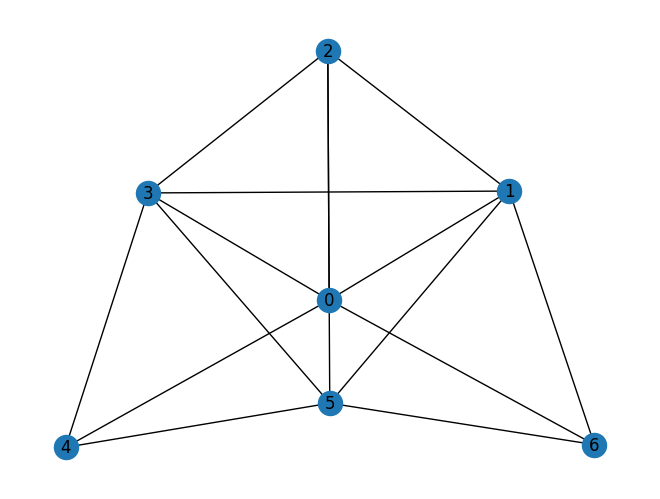

In [2]:
graph = nx.erdos_renyi_graph(7, 0.6, seed=79)
nx.draw_kamada_kawai(graph, with_labels=True)
max_clique_model = define_max_clique_model(graph)

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` quantum object. Under the hood it tranlates the pyomo model to a quantum model of the QAOA algorithm [[1](#QAOA)], with cost hamiltonian translated from the pyomo model. We can choose the number of layers for the qaoa ansatz using the argument `num_layers`.

In [3]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=max_clique_model, num_layers=20)

qmod = combi.get_model()

In [4]:
write_qmod(qmod, "max_clique")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [ ]:
qprog = combi.get_qprog()
show(qprog)

We also set the quantum backend we want to execute on:

In [6]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[2](#cvar)]:

In [7]:
optimized_params = combi.optimize(execution_preferences, maxiter=1, quantile=1)

# Optimization Results

We can also examine the statistics of the algorithm. The optimization is always defined as a minimzation problem, so the positive maximization objective was tranlated to a negative minimization one by the pyomo to qmod translator.

In order to get samples with the optimized parameters, we call the `get_results` method:

In [8]:
optimization_result = combi.get_results()
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
99,"{'x_0': 0, 'x_1': 1, 'x_2': 1, 'x_3': 1, 'x_4'...",0.000977,-4.0
102,"{'x_0': 1, 'x_1': 1, 'x_2': 1, 'x_3': 1, 'x_4'...",0.000977,-4.0
17,"{'x_0': 1, 'x_1': 0, 'x_2': 0, 'x_3': 1, 'x_4'...",0.015137,-3.0
26,"{'x_0': 0, 'x_1': 1, 'x_2': 1, 'x_3': 0, 'x_4'...",0.012695,-3.0
27,"{'x_0': 1, 'x_1': 1, 'x_2': 0, 'x_3': 1, 'x_4'...",0.012695,-3.0


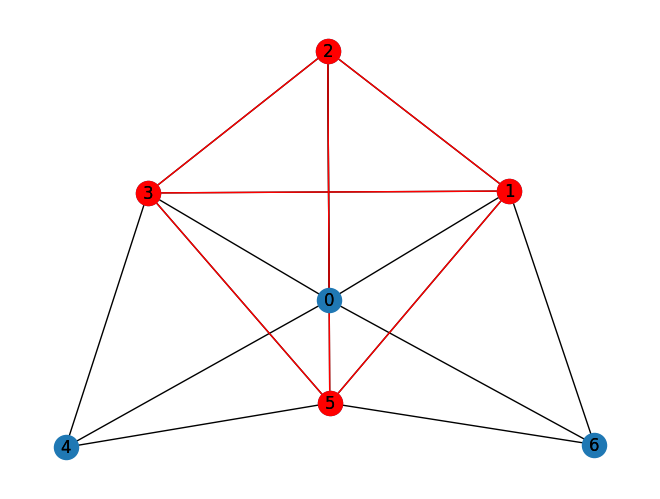

In [9]:
solution = optimization_result.solution[optimization_result.cost.idxmin()]
solution_nodes = [v for v in graph.nodes if solution[f"x_{v}"]]
solution_edges = [
    (u, v) for u, v in graph.edges if u in solution_nodes and v in solution_nodes
]
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=solution_nodes,
    edgelist=solution_edges,
    node_color="r",
    edge_color="r",
)

And the histogram:

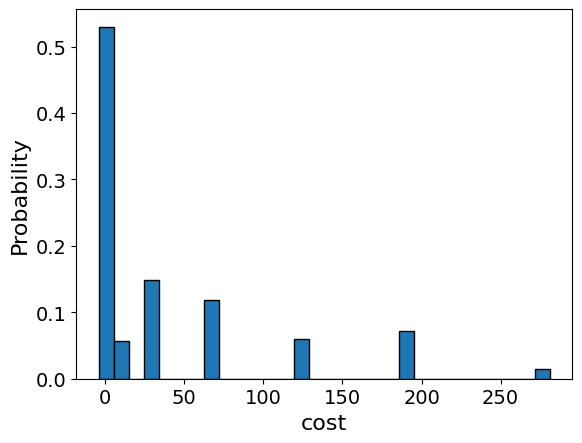

In [13]:
import matplotlib.pyplot as plt

optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [14]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x_0': 0, 'x_1': 1, 'x_2': 1, 'x_3': 1, 'x_4': 0, 'x_5': 1, 'x_6': 0}

## Comparison to a classical solver

Lastly, we can compare to the classical solution of the problem:

In [15]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(max_clique_model)
classical_solution = [
    int(pyo.value(max_clique_model.x[i])) for i in range(len(max_clique_model.x))
]
print("Classical solution:", classical_solution)

Classical solution: [1, 1, 1, 1, 0, 0, 0]


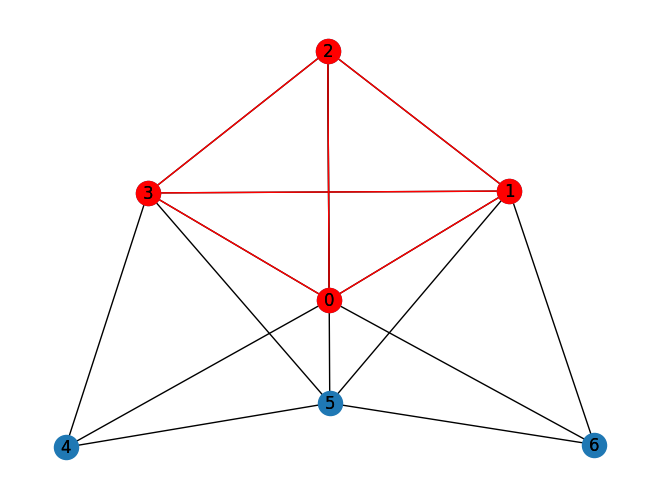

In [16]:
solution = [int(pyo.value(max_clique_model.x[i])) for i in graph.nodes]
solution_nodes = [v for v in graph.nodes if solution[v]]
solution_edges = [
    (u, v) for u, v in graph.edges if u in solution_nodes and v in solution_nodes
]
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=solution_nodes,
    edgelist=solution_edges,
    node_color="r",
    edge_color="r",
)


## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[2]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
